In [17]:
import pandas as pd

import requests as req
import matplotlib.pyplot as plt

import gensim.parsing.preprocessing as gpp
import gensim.utils as gu
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:
!pip install requests tarfile

ERROR: Could not find a version that satisfies the requirement tarfile (from versions: none)
ERROR: No matching distribution found for tarfile


In [3]:
import requests

url = "https://s3.amazonaws.com/fast-ai-nlp/amazon_review_full_csv.tgz"
filename = url.split("/")[-1]

response = requests.get(url)

if response.status_code == 200:
  with open(filename, 'wb') as f:
    f.write(response.content)
  print(f"Downloaded {filename}")
else:
  print(f"Failed to download the file: {response.status_code}")

Downloaded amazon_review_full_csv.tgz


In [4]:
import tarfile

with tarfile.open(filename, "r:gz") as tar:
  tar.extractall()

print(f"Extracted files from {filename}")

Extracted files from amazon_review_full_csv.tgz


In [5]:
%cd amazon_review_full_csv
!pwd

/content/amazon_review_full_csv
/content/amazon_review_full_csv


In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [7]:
train.rename(columns = {'3':"rating","more like funchuck":"Title",'''Gave this to my dad for a gag gift after directing "Nunsense," he got a reall kick out of it!''':"review"},inplace = True)
train.head()

,rating,Title,review
0,5,Inspiring,I hope a lot of people hear this cd. We need m...
1,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
3,5,Too good to be true,Probably the greatest soundtrack in history! U...
4,5,There's a reason for the price,"There's a reason this CD is so expensive, even..."


In [8]:
test.rename(columns = {'1':'rating',"mens ultrasheer":"Title",'''This model may be ok for sedentary types, but I'm active and get around alot in my job - consistently found these stockings rolled up down by my ankles! Not Good!! Solution: go with the standard compression stocking, 20-30, stock #114622. Excellent support, stays up and gives me what I need. Both pair of these also tore as I struggled to pull them up all the time. Good riddance/bad investment!''':"review"}, inplace = True)
test.head()

,rating,Title,review
0,4,Surprisingly delightful,This is a fast read filled with unexpected hum...
1,2,"Works, but not as advertised",I bought one of these chargers..the instructio...
2,2,Oh dear,I was excited to find a book ostensibly about ...
3,2,Incorrect disc!,"I am a big JVC fan, but I do not like this mod..."
4,2,Incorrect Disc,"I love the style of this, but after a couple y..."


(array([129999.,      0., 130000.,      0.,      0., 130000.,      0.,
        130000.,      0., 130000.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

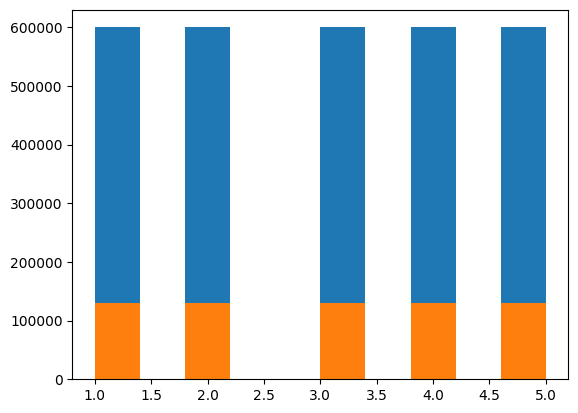

In [9]:
plt.hist(train['rating'])
plt.hist(test['rating'])

In [10]:
def preprocess_text(text):

    preprocs = [
        gpp.strip_tags,
        gpp.strip_punctuation,
        gpp.strip_multiple_whitespaces,
        gpp.strip_numeric,
        gpp.remove_stopwords,
        gpp.strip_short,
    ]
    text = gu.to_unicode(text.lower().strip())
    for preproc in preprocs:
        text = preproc(text)
    return text


preprocess = lambda text: preprocess_text(str(text))

In [11]:
train1 = train[0:10000]
test1 = test[0:10000]
train1["ReviewFull"] = train1["Title"] + " " + train1["review"]
train1 = train1.drop(["Title", "review"], axis=1)

train1["ReviewFull"] = train1["ReviewFull"].apply(preprocess)
train1.head()

<ipython-input-11-a19cdaec687f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1["ReviewFull"] = train1["Title"] + " " + train1["review"]


,rating,ReviewFull
0,5,inspiring hope lot people hear need strong pos...
1,5,best soundtrack reading lot reviews saying bes...
2,4,chrono cross ost music yasunori misuda questio...
3,5,good true probably greatest soundtrack history...
4,5,reason price reason expensive version import b...


In [12]:
test1["ReviewFull"] = test1["Title"] + " " + test1["review"]
test1 = test1.drop(["Title", "review"], axis=1)

test1["ReviewFull"] = test1["ReviewFull"].apply(preprocess)
test1.head()

<ipython-input-12-f7e8a922d7d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1["ReviewFull"] = test1["Title"] + " " + test1["review"]


,rating,ReviewFull
0,4,surprisingly delightful fast read filled unexp...
1,2,works advertised bought chargers instructions ...
2,2,dear excited book ostensibly muslim feminism v...
3,2,incorrect disc big jvc fan like model suspisci...
4,2,incorrect disc love style couple years dvd giv...


In [13]:
train_df = train1
test_df = test1
X_train = train_df["ReviewFull"].tolist()
y_train = train_df["rating"].tolist()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [34]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))

8000
8000
2000
2000


In [14]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def bert_encode(text_list, max_len=512):
    encoded_inputs = tokenizer(text_list, padding="max_length", truncation=True, max_length=max_len)
    input_ids = encoded_inputs["input_ids"]
    attention_masks = encoded_inputs["attention_mask"]
    token_type_ids = encoded_inputs.get("token_type_ids", None)
    return input_ids, attention_masks, token_type_ids


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
train_input_ids, train_attention_masks, train_token_type_ids = bert_encode(X_train)
val_input_ids, val_attention_masks, val_token_type_ids = bert_encode(X_val)

In [35]:
print(type(train_attention_masks))

<class 'list'>


In [16]:
model_name = "bert-base-uncased"
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:

model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [ ]:
model.fit(
    x=[train_input_ids, train_attention_masks, train_token_type_ids],
    y=y_train,
    epochs=3,
    batch_size=8,
    validation_data=(
        [val_input_ids, val_attention_masks, val_token_type_ids],
        y_val,
    ),
)

In [ ]:
test_input_ids, test_attention_masks, test_token_type_ids = bert_encode(test_df["ReviewFull"].tolist())

In [ ]:
predictions = model.predict([test_input_ids, test_attention_masks, test_token_type_ids])  # Adjust for model requirements
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_df["rating"], predicted_classes))


model.save("sentiment_analysis_model.h5")


loaded_model = tf.keras.models.load_model("sentiment_analysis_model.h5")


new_review = "This is an excellent product!"
new_review_encoded = bert_encode([new_review])
new_prediction = loaded_model.predict(new_review_encoded)
predicted_sentiment = np.argmax(new_prediction, axis=1)[0]
print(f"Predicted sentiment for '{new_review}': {predicted_sentiment}")

In [ ]:
import requests
from bs4 import BeautifulSoup
import http.cookiejar as cookielib
import pandas as pd

In [ ]:

custom_headers = {
    "Accept-language": "en-GB,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Cache-Control": "max-age=0",
    "Connection": "keep-alive",
    "User-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.1 Safari/605.1.15",
}

def get_soup(url):
    response = requests.get(url, headers=custom_headers)

    if response.status_code != 200:
        print("Error in getting webpage")
        exit(-1)

    soup = BeautifulSoup(response.text, "lxml")
    return soup

def get_reviews(soup):
    review_elements = soup.select("div.review")

    scraped_reviews = []

    for review in review_elements:
        r_author_element = review.select_one("span.a-profile-name")
        r_author = r_author_element.text if r_author_element else None

        r_rating_element = review.select_one("i.review-rating")
        r_rating = r_rating_element.text.replace("out of 5 stars", "") if r_rating_element else None

        r_title_element = review.select_one("a.review-title")
        r_title_span_element = r_title_element.select_one("span:not([class])") if r_title_element else None
        r_title = r_title_span_element.text if r_title_span_element else None

        r_content_element = review.select_one("span.review-text")
        r_content = r_content_element.text if r_content_element else None

        r_date_element = review.select_one("span.review-date")
        r_date = r_date_element.text if r_date_element else None

        r_verified_element = review.select_one("span.a-size-mini")
        r_verified = r_verified_element.text if r_verified_element else None

        r_image_element = review.select_one("img.review-image-tile")
        r_image = r_image_element.attrs["src"] if r_image_element else None

        r = {
            "author": r_author,
            "rating": r_rating,
            "title": r_title,
            "content": r_content,
            "date": r_date,
            "verified": r_verified,
            "image_url": r_image
        }

        scraped_reviews.append(r)

    return scraped_reviews

def main():
    search_url = "https://www.amazon.in/boAt-Nirvana-Technology-Detection-Bluetooth/product-reviews/B0BW8TXJJ2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=2"
    soup = get_soup(search_url)
    data = get_reviews(soup)
    df = pd.DataFrame(data=data)
    df.to_csv("amz.csv")

main()

In [ ]:
review = pd.read_csv('amz.csv')
review.head()

,Unnamed: 0,author,rating,title,content,date,verified,image_url
0,0,Praveen Singh Chouhan,4.0,Expensive,\nI like it's pakaging and sound quality or pl...,Reviewed in India on 23 April 2024,Verified Purchase,NaN
1,1,Vinayak Dubey,4.0,Heavy,\nNice sound quality and good noice cancellati...,Reviewed in India on 23 April 2024,Verified Purchase,NaN
2,2,Naveen Khatkar,4.0,Awesome sound quality,\nSound quality is best with noise cancellation\n,Reviewed in India on 28 April 2024,Verified Purchase,NaN
3,3,Nice product and good sound quality.,4.0,Nice,\nGood sound quality and battery back up.\n,Reviewed in India on 27 April 2024,Verified Purchase,NaN
4,4,SHREYAS GOTHANKAR,4.0,Value for money,\nOverall good productI hated the intial equil...,Reviewed in India on 31 March 2024,Verified Purchase,NaN
